In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras


In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = '/content/drive/MyDrive/DL/House_prices/train.csv'
test_path = '/content/drive/MyDrive/DL/House_prices/test.csv'

In [4]:
train = open(train_path)
test = open(test_path)
df1 = pd.read_csv(train)
df2 = pd.read_csv(test)

train_df = pd.DataFrame(df1)
test_df =pd.DataFrame(df2)
test_df.head(2)

train_df_3m = train_df[train_df['SalePrice'] <= 3000000]
train_df_3m.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [17]:
train_df_3m['SalePrice'].max()

755000

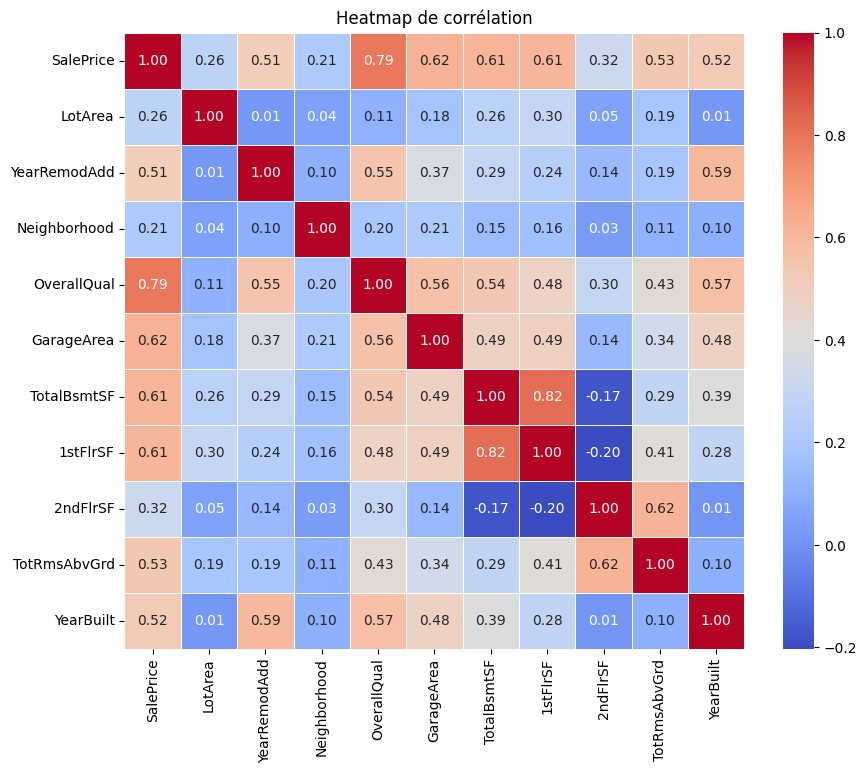

In [18]:
#Matrice de corrélation:
interesting_columns = ['SalePrice', 'LotArea', 'YearRemodAdd', 'Neighborhood', 'OverallQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'YearBuilt']
interesting_df = train_df_3m[interesting_columns].copy()
le = LabelEncoder()
#interesting_df['BldgType'] = le.fit_transform(interesting_df['BldgType'])
interesting_df['Neighborhood'] = le.fit_transform(interesting_df['Neighborhood'])
#interesting_df['ExterCond'] = le.fit_transform(interesting_df['ExterCond'])
correlation_matrix = interesting_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap de corrélation")
plt.show()

#Repère dans quelles colonne sil y a des #N/A
#columns_with_missing_values = interesting_df.columns[interesting_df.isna().any()].tolist()



In [6]:
interesting_columns_without_price = ['LotArea', 'YearRemodAdd', 'Neighborhood', 'OverallQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'YearBuilt']
interesting_test_df = test_df[interesting_columns_without_price].copy()

In [16]:
#Repère dans quelles colonne sil y a des #N/A
columns_with_missing_values = interesting_test_df.columns[interesting_test_df.isna().any()].tolist()
columns_with_missing_values

['GarageArea', 'TotalBsmtSF']

In [28]:
interesting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     1460 non-null   int64
 1   LotArea       1460 non-null   int64
 2   YearRemodAdd  1460 non-null   int64
 3   Neighborhood  1460 non-null   int64
 4   OverallQual   1460 non-null   int64
 5   GarageArea    1460 non-null   int64
 6   TotalBsmtSF   1460 non-null   int64
 7   1stFlrSF      1460 non-null   int64
 8   2ndFlrSF      1460 non-null   int64
 9   TotRmsAbvGrd  1460 non-null   int64
 10  YearBuilt     1460 non-null   int64
dtypes: int64(11)
memory usage: 125.6 KB


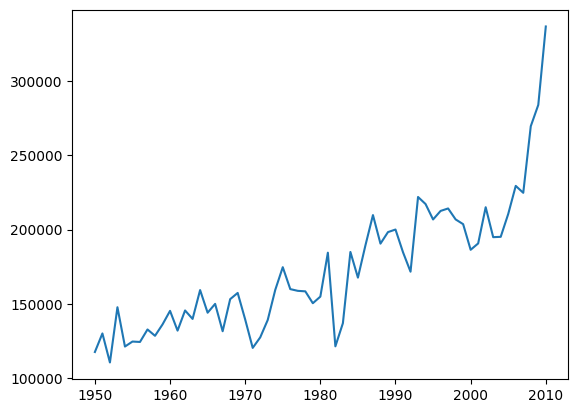

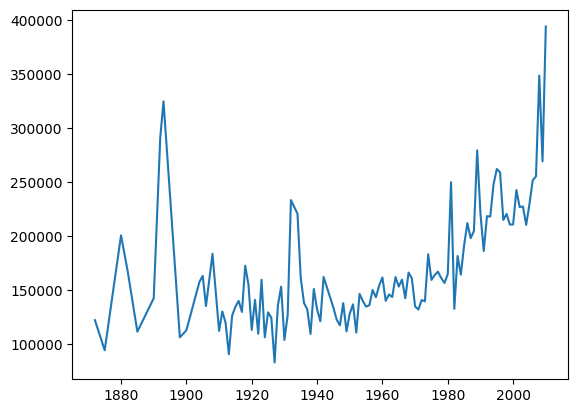

In [19]:
#Datavisualisation
'''LandSlope_count = train_df['LandSlope'].value_counts() ##Compte le nombre de logements par valeur de ce qu'il y a entre ''
print(LandSlope_count)'''

#sns.scatterplot(x='OverallQual', y='SalePrice', data=train_df)

##YearRemodAdd
#Distribution des prix
'''sns.scatterplot(x='YearRemodAdd', y='SalePrice', data=train_df)
plt.title('Distribution des prix en fonction de BldgType')
plt.xlabel('BldgType')
plt.ylabel('Prix de vente')
plt.show()'''

#Nombre de data par année
'''plt.figure(figsize=(10, 6))  # Ajuster la taille du graphique si nécessaire
plt.hist(train_df['YearRemodAdd'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution de YearRemodAdd')
plt.xlabel('Année de l\'ajout de rénovation')
plt.ylabel('Nombre de logements')
plt.show()'''

yearremod_data = train_df.groupby('YearRemodAdd')['SalePrice'].mean()
plt.plot(yearremod_data.index, yearremod_data.values)
plt.show()

yearbuilt_data = train_df.groupby('YearBuilt')['SalePrice'].mean()
plt.plot(yearbuilt_data.index, yearbuilt_data.values)


#Commentaire : enlever utilities, ajouter YearRemodAdd
#Inutiles : Utilities, LandSlope, BldgType, OverallCond
#Utiles : YearRemodAdd

In [20]:

from sklearn.preprocessing import MinMaxScaler
X = train_df_3m.drop('SalePrice', axis =1)
y = train_df_3m['SalePrice']
pd.DataFrame(X)

X_train_full, X_temp, y_train, y_temp = train_test_split(X,y, test_size = 0.3, random_state= 42)
X_val_full, X_test_full, y_valid, y_test = train_test_split(X_temp,y_temp, test_size= 0.5, random_state=42)


X_train = X_train_full[['LotArea', 'YearRemodAdd', 'Neighborhood', 'OverallQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'YearBuilt']].copy()
X_test = X_test_full[['LotArea', 'YearRemodAdd', 'Neighborhood', 'OverallQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'YearBuilt']].copy()
X_valid = X_val_full[['LotArea', 'YearRemodAdd', 'Neighborhood', 'OverallQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'YearBuilt']].copy()
X_train['Neighborhood'] = le.fit_transform(X_train['Neighborhood'])
X_test['Neighborhood'] = le.fit_transform(X_test['Neighborhood'])
X_valid['Neighborhood'] = le.fit_transform(X_valid['Neighborhood'])





In [33]:
y_test.max()

755000

In [25]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [26]:
input_ = keras.layers.Input(X_train.shape[1])
hidden1 = keras.layers.Dense(20, activation = "relu")(input_)
hidden2 = keras.layers.Dense(20, activation = "relu")(hidden1)
output = keras.layers.Dense(1)(hidden2)
model = keras.Model(inputs = [input_], outputs = [output] )

In [27]:
#TensorBoard
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

# tensorboard --logdir=./my_logs --port=6006 :à rentrer dans le terminal

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss = "mean_squared_error", optimizer="adam")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, batch_size = 128, epochs = 2000, validation_data=(X_valid, y_valid), callbacks = [tensorboard_cb, early_stopping])

Epoch 1/2000
8/8 [==============================] - 1s 41ms/step - loss: 1896522112.0000 - val_loss: 1641391360.0000
Epoch 2/2000
8/8 [==============================] - 0s 10ms/step - loss: 1895564544.0000 - val_loss: 1640858368.0000
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 1895092864.0000 - val_loss: 1640610304.0000
Epoch 4/2000
8/8 [==============================] - 0s 10ms/step - loss: 1894771584.0000 - val_loss: 1639772672.0000
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 1894214400.0000 - val_loss: 1639073664.0000
Epoch 6/2000
8/8 [==============================] - 0s 8ms/step - loss: 1893638144.0000 - val_loss: 1638737280.0000
Epoch 7/2000
8/8 [==============================] - 0s 11ms/step - loss: 1893122304.0000 - val_loss: 1638270464.0000
Epoch 8/2000
8/8 [==============================] - 0s 9ms/step - loss: 1892667392.0000 - val_loss: 1637698816.0000
Epoch 9/2000
8/8 [==============================] - 0s 9ms/step - lo

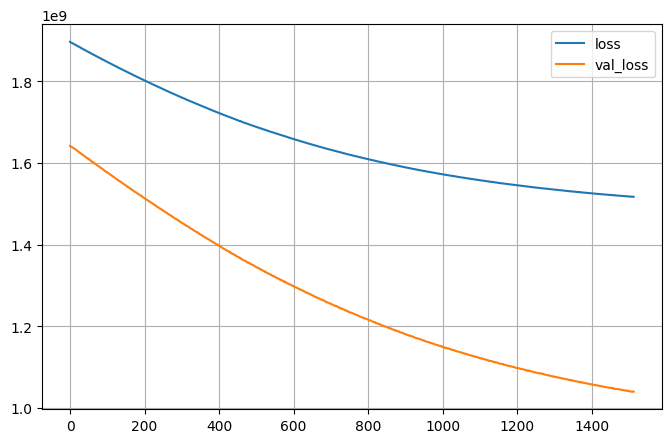

In [30]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)

In [31]:
# predictions on the test set
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,explained_variance_score
predictions = model.predict(X_test)

print('MAE: ',mean_absolute_error(y_test,predictions))
print('MSE: ',mean_squared_error(y_test,predictions))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,predictions)))
print('Variance Regression Score: ',explained_variance_score(y_test,predictions))

print('\n\nDescriptive Statistics:\n',df1['SalePrice'].describe())

7/7 [==============================] - 0s 3ms/step
MAE:  25200.142689604738
MSE:  1942312167.5246263
RMSE:  44071.67080477692
Variance Regression Score:  0.7462131524043338


Descriptive Statistics:
 count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


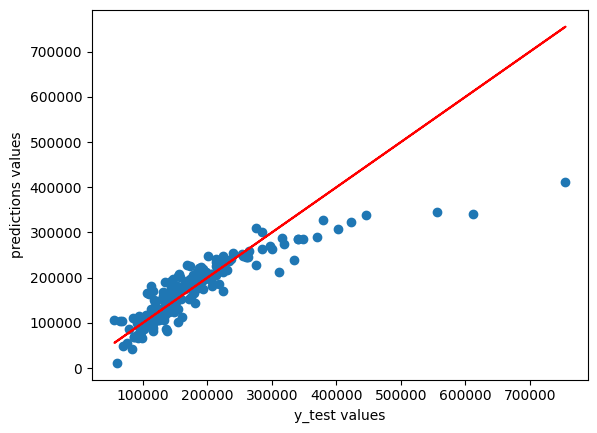

In [32]:
plt.scatter(y_test, predictions)
plt.plot(y_test,y_test,'r')
plt.xlabel('y_test values')
plt.ylabel('predictions values')
plt.show()

In [55]:
X_test_submission = df2[['LotArea', 'YearRemodAdd', 'Neighborhood', 'OverallQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'YearBuilt']].copy()
X_test_submission['Neighborhood'] = le.fit_transform(X_test_submission['Neighborhood'])
#X_test_submission['Utilities'] = le.fit_transform(X_test_submission['Utilities'])
'''rows_with_nan = X_test_submission[X_test_submission['TotalBsmtSF'].isna()]
print(rows_with_nan)'''
X_test_submission['GarageArea'].fillna(X_test_submission['GarageArea'].mean(), inplace =True)
X_test_submission['TotalBsmtSF'].fillna(X_test_submission['TotalBsmtSF'].mean(), inplace =True)
X_test_submission = scaler.transform(X_test_submission)
X_test_submission



array([[0.04824604, 0.18333333, 0.5       , ..., 0.        , 0.25      ,
        0.64492754],
       [0.06060904, 0.13333333, 0.5       , ..., 0.        , 0.33333333,
        0.62318841],
       [0.05856645, 0.8       , 0.33333333, ..., 0.33946731, 0.33333333,
        0.9057971 ],
       ...,
       [0.08740564, 0.76666667, 0.45833333, ..., 0.        , 0.41666667,
        0.63768116],
       [0.04272593, 0.7       , 0.45833333, ..., 0.        , 0.33333333,
        0.86956522],
       [0.03892122, 0.73333333, 0.45833333, ..., 0.48619855, 0.58333333,
        0.87681159]])

In [56]:
y_pred2 = model.predict(X_test_submission)
y_pred2


46/46 [==============================] - 0s 1ms/step


array([[137938.66],
       [149695.05],
       [181105.45],
       ...,
       [177753.11],
       [119401.89],
       [240807.22]], dtype=float32)

In [57]:
y_pred = pd.DataFrame(data = y_pred2, columns = ['SalePrice'])
pd.DataFrame(y_pred)

,SalePrice
0,137938.656250
1,149695.046875
2,181105.453125
3,194690.468750
4,205066.390625
...,...
1454,76638.085938
1455,100359.187500
1456,177753.109375
1457,119401.890625


In [58]:
result_df = pd.DataFrame({'Id' : df2['Id'], 'SalePrice' :y_pred['SalePrice'] })
save_path = '/content/drive/MyDrive/DL/House_prices/predictions_nn2.csv'
result_df.to_csv(save_path, index=False)
